# Optimized energy scenarios for Val di Non

Author: Michele Urbani ([murbani@fbk.eu](mailto:murbani@fbk.eu))

In this notebook, we replicate the study in {cite:ps}`MAHBUB20171487`.

## Problem description

The original paper considers three scenarios for changing temperatures, i.e.,
2°C, 4°C, and 6°C.
In this notebook, we replicate only the study for a 2°C temperature increase.

### Decision variables

The decision variables are:

1. **PV capacity**: the amount of installed PV capacity is 936 kW and it is
as the lower bound for the variable, whereas the calculated maximum PV capacity
is 40 MW, which is the upper bound.
2. **Heat production technologies**: individual oil, LPG, biomass, and heat
pump production are decision variables expressed as percentages of the total
heat production. **Solar thermal** is also considered and it can be obtained by
oil, LPG, biomass, and heat pumps as a share of the total solar thermal
production.
3. **Electric cars in the system** are a decision variable that defines the
percentage of electric cars in the system. Cars that are not electric adopt
internal combustion engine technologies.

### Constraints

The annual biomass consumption is limited to 98.84 GWh/year.

### Optimization objectives

There are two optimization objectives.

1. **CO$_2$ minimization**: the value of produced CO$_2$ is
``CO2-emission (corrected)`` in EnergyPLAN output.
2. **Annual cost minimization**: the annual cost is the sum of the annual
investment cost, variable operational and maintenance (O&M) cost, fixed
operational and maintenacne cost, and the variable O&M and fixed O&M costs.

## Problem declaration

The paper tackles a multi-period problem, where at each time step the energy
system is optimized according to the decision taken during the previous time
step. A time step represents a year and the years selected for the multi-period
analysis are 2020, 2030, and 2050.

To better control the exectution of the analys, scenarios are defined
independently of the algorithm, and will be provided as parameters during the
initialization stage.

In [1]:
import pandas as pd

common_data = dict(
    co2Coal                         = 95.0,  # unit: kg/GJ
    co2Oil                          = 74.0,
    co2NGas                         = 56.7,
    averageKMPerYearPerCar          = 12900,
    totalKMRunByCars                = 25 * 1e7,
)

scenarios = {
    "2020": dict(
		totalHeatDemand             = 253.70,  # in GWh
		efficiencyConCar            = 0.607,  # KWh/km
		efficiencyEVCar             = 0.169 / 0.85,  # KWh/km; divided by 0.85 (which is "round-trip battery efficiency)
		efficiencyFCEVCar           = 0.334,  # KWh/km
		efficiencyBiomassCHP        = 0.66,
		efficiencyElectrolyzerTrans = 0.74,
		oilBoilerEfficiency         = 0.85,
		nGasBoilerEfficiency        = 0.95,
		biomassBoilerEfficiency     = 0.80,
		COP                         = 4.54,
		coalShare                   = 14.0,
		oilShare                    = 5.6,
		nGasShare                   = 45.0,
		additionalCostPerGWhinKEuro = 136.36,
    ),
    "2030": dict(
		totalHeatDemand             = 249.84,  # in GWh
		efficiencyConCar            = 0.549,  # KWh/km
		efficiencyEVCar             = 0.145 / 0.85,  # KWh/km; divided by 0.85 (which is "round-trip battery efficiency)
		efficiencyFCEVCar           = 0.267,  # KWh/km
		efficiencyBiomassCHP        = 0.66,
		efficiencyElectrolyzerTrans = 0.75,
		oilBoilerEfficiency         = 0.87,
		nGasBoilerEfficiency        = 0.97,
		biomassBoilerEfficiency     = 0.82,
		COP                         = 5.07,
		coalShare                   = 10.4,
		oilShare                    = 4.1,
		nGasShare                   = 33.4,
		additionalCostPerGWhinKEuro = 144.33,
    ),
    "2050": dict(
		totalHeatDemand             = 256.11,  # in GWh
		efficiencyConCar            = 0.497,  # KWh/km
		efficiencyEVCar             = 0.117 / 0.85,  # KWh/km; divided by 0.85 (which is "round-trip battery efficiency)
		efficiencyFCEVCar           = 0.200,  # KWh/km
		efficiencyBiomassCHP        = 0.66,
		efficiencyElectrolyzerTrans = 0.78,
		oilBoilerEfficiency         = 0.89,
		nGasBoilerEfficiency        = 0.99,
		biomassBoilerEfficiency     = 0.84,
		COP                         = 5.46,
		coalShare                   = 3.3,
		oilShare                    = 1.3,
		nGasShare                   = 10.5,
		additionalCostPerGWhinKEuro = 158.37,
    )
}

scenarios = {k: {**common_data, **v} for k, v in scenarios.items()}

df = pd.DataFrame(scenarios)

df.to_csv("vdn-scenarios.csv")


The reference scenario represents the year 2008. We read the parameters file
and store the values for later use in the definition of *transient scenarios*.

In [2]:
from moea.utils import parse_input
from moea.config import ENERGYPLAN_DATA_DIR

reference_scenario = ENERGYPLAN_DATA_DIR / "VdN_SH_2008.txt"

reference_parameters = parse_input(reference_scenario)

2024-12-11 17:22:18.816 | INFO     | moea.config:<module>:11 - PROJ_ROOT path is: C:\Users\murbani\moea


Since the same model is used for the analysis of multiple scenarios, it
must be initialized providing the year and the parameters for the specific
scenario.

In [3]:
import pickle
import pandas as pd
from time import time
from pymoo.optimize import minimize

from moea.config import logger
from moea.models import get_model
from moea.algorithms import get_algorithm

scenarios = pd.read_csv("vdn-scenarios.csv", index_col=0)


In this section, energy planning is optimized for the years 2020, 2030, and
2050. Transient scenarios are identified in the next sections.

In [4]:
model_name = 'vdn'
pop_size = 150
algorithm_name = 'mahbub2016'

for year in [2020, 2030, 2050]:
    logger.info(f"Start optimization for {year}.")
    # Declare model and algorithm
    model = get_model(
        model_name,
        year=year,
        scenario=scenarios[str(year)],
        data_file=f"VdN_SH_{year}_Opt_Scenario_2DS_El_mob.txt",
    )
    algorithm = get_algorithm(algorithm_name, pop_size=pop_size)
    # Run optimization
    t_start = time()
    res = minimize(
        model,
        algorithm,
        ('n_gen', 200),
        seed=1234,
        verbose=True,
    )
    t_end = time()
    logger.info(f"Optimization for {year} took {t_start - t_end:.2f} seconds.")
    # Save the results to separate the optimization and analysis
    with open(f"results_{model_name}_{algorithm_name}_{year}.pkl", "wb") as f:
        pickle.dump(res, f)


2024-12-11 17:22:18.950 | INFO     | __main__:<module>:12 - Start optimization for 2020.


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      8 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      300 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0881963493 |         ideal
     3 |      450 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0110296167 |         ideal
     4 |      600 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0094607462 |         ideal
     5 |      750 |      9 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      900 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0565244566 |         ideal
     7 |     1050 |      9 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |     1200 |      9 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |     1350 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0104330833 |             f
    10 |     1500 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

2024-12-12 05:40:55.772 | INFO     | __main__:<module>:31 - Optimization for 2020 took -44314.75 seconds.
2024-12-12 05:40:55.783 | INFO     | __main__:<module>:12 - Start optimization for 2030.


   200 |    30000 |     32 |  0.000000E+00 |  0.000000E+00 |  0.0011018963 |             f
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      5 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      300 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0792981570 |         ideal
     3 |      450 |      6 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |      600 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0645860129 |             f
     5 |      750 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0530296626 |             f
     6 |      900 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0269848523 |             f
     7 |     1050 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |     1200 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0247567387 |         ideal
     9 |     1350 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0442750861 |         ideal

2024-12-12 18:19:10.280 | INFO     | __main__:<module>:31 - Optimization for 2030 took -45494.46 seconds.
2024-12-12 18:19:10.291 | INFO     | __main__:<module>:12 - Start optimization for 2050.


   200 |    30000 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0017913889 |             f
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      3 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      300 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0666203364 |         ideal
     3 |      450 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0308543059 |             f
     4 |      600 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      750 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      900 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |     1050 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |     1200 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |     1350 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

2024-12-13 06:38:44.949 | INFO     | __main__:<module>:31 - Optimization for 2050 took -44374.62 seconds.


   200 |    30000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


## Results analysis

The Pareto front shows the possible cost-emissions trade-offs that could
potentially be achieved starting from the cofiguration for the year 2008
(represented by the red marker in the plot).

In [5]:
import numpy as np
# Compute the CO2 emissions and the annual cost for the reference scenario
from pathlib import Path

from moea.utils import execute_energyplan, parse_output
from moea.config import ENERGYPLAN_DATA_DIR

output_file = Path("VdN_SH_2008_output.txt")

# Run EnergyPLAN for the reference scenario
reference_results = execute_energyplan(
    input_file=ENERGYPLAN_DATA_DIR / "VdN_SH_2008.txt",
    output_file=output_file,
)
# Parse the output file to get the results
D = parse_output(output_file)

localCO2emission = float(
    D['ANNUAL CO2 EMISSIONS (kt)']['CO2-emission (total)']
)
annual_costs = D['ANNUAL COSTS (k EUR)']['TOTAL']
totalVariableCost = float(annual_costs.loc['Variable costs'])
fixedOperationalCost = float(annual_costs.loc['Fixed operation costs'])
investmentCost = float(annual_costs.loc['Annual Investment costs'])

annual_lbl = [i for i in D.keys() if 'TOTAL FOR ONE YEAR' in i][0]
fuel_lbl = [i for i in D.keys() if 'ANNUAL FUEL' in i][0]

hydro = float(D[annual_lbl]["Hydro Electr."])
pv = float(D[annual_lbl]["PV Electr."].max())
el_import = float(D[annual_lbl]["Import Electr."])
el_export = float(D[annual_lbl]["Export Electr."])
hh_chp = float(D[annual_lbl]["HH-CHP Electr."])

# Compute the first objective: local CO2 emissions

# Breakdown import electricity cost
co2InImportedEleCoal = el_import * 0.156 * common_data["co2Coal"] * 3600 / 1e6
co2InImportedEleOil = el_import * 0.062 * common_data["co2Oil"] * 3600 / 1e6
co2InImportedEleNGas = el_import * 0.501 * common_data["co2NGas"] * 3600 / 1e6

# Calculate local CO2 emissions
CO2Emission = localCO2emission + co2InImportedEleCoal + \
    co2InImportedEleOil + co2InImportedEleNGas

# The annual actual cost is retrieved from the authors' repository
annualActualCost = 140863.0

reference = np.array([CO2Emission, annualActualCost])


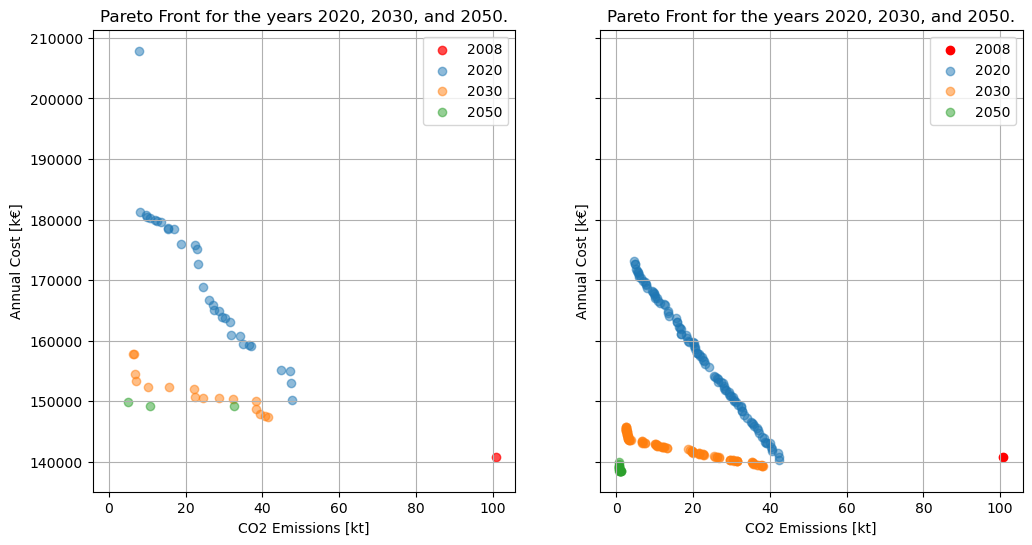

In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
# Print scatter plot with Pareto front

years = [2020, 2030, 2050]
model_name = 'vdn'
algorithm_name = 'mahbub2016'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot the Pareto front obtained by the algorithm
ax = ax1
# Add the reference point
ax.scatter(reference[0], reference[1], label='2008', color='red', alpha=0.7)
# Iterate over the years
for year in years:
    # Load the results
    with open(f"results_{model_name}_{algorithm_name}_{year}.pkl", "rb") as f:
        res = pickle.load(f)
    # Plot the Pareto front
    ax.scatter(res.F[:, 0], res.F[:, 1], label=year, alpha=0.5)
ax.set_xlabel('CO2 Emissions [kt]')
ax.set_ylabel('Annual Cost [k€]')
ax.set_title(f'Pareto Front for the years 2020, 2030, and 2050.')
ax.grid()
ax.legend()

ax = ax2
# Add the reference point
ax.scatter(reference[0], reference[1], label='2008', color='red')
# Plot the reference Pareto front
for year in years:
    # Load the results
    df = pd.read_csv(f"vdn-{year}-reference-pf.csv",
                     sep="\s+",
                     names=["CO2 Emissions [kt]", "Annual Cost [k€]"])
    # Plot the reference Pareto front
    ax.scatter(
        df["CO2 Emissions [kt]"],
        df["Annual Cost [k€]"],
        label=year,
        alpha=0.5,
    )
ax.set_xlabel('CO2 Emissions [kt]')
ax.set_ylabel('Annual Cost [k€]')
ax.set_title(f'Pareto Front for the years 2020, 2030, and 2050.')
ax.grid()
ax.legend()
plt.show()


### Convergence analysis

The results of the paper {cite:t}`MAHBUB20171487` are used as reference to
measure the quality of the solution. We implement the Inverted Generational
Distance (IGD) {cite:t}`COELLOCOELLO2004688` to quantify the distance from any
point in the set of solutions $Z$ to the closest point in the set of
reference solutions $A$.

$$
IGD(A) = \frac{1}{|Z|} \left( \sum_{i=1}^{|Z|} \hat{d}_i ^{\,p} \right) ^{1/p}
$$

where $\hat{d}_i$ represents the Euclidean distance ($p=2$) from $z_i$ to its
nearest reference point in $A$.

The lower the value of the IGD, the closer the set $A$ to the reference set
$Z$.

In [7]:
from pymoo.indicators.igd import IGD

for year in years:
    # Load reference Pareto front
    df = pd.read_csv(f"vdn-{year}-reference-pf.csv",
                     sep="\s+",
                     names=["CO2 Emissions [kt]", "Annual Cost [k€]"])
    # Initialize the IGD indicator
    ind = IGD(df.values)
    # Load the results
    with open(f"results_{model_name}_{algorithm_name}_{year}.pkl", "rb") as f:
        res = pickle.load(f)
    # Compute the IGD
    print(f"IGD for {year}: {ind(res.F)}")

IGD for 2020: 1854.642830800136
IGD for 2030: 5091.610424052202
IGD for 2050: 10326.05814920391


## Selection of optimized target scenarios

Target scenario are identified according to the target CO2 emissions reduction,
which are defined as percentage range for each year with respect to the
reference scenario year 2008.
The reduction ranges are 50-55%, 65-70%, and 95-100% for the years 2020, 2030,
and 2050, respectively.

The number of scenarios identified according to the targets might be too large
to be analyzed and it might be necessary to further reduce the considered
scenario. In the paper, the authors considered 10 target scenarios to conduct
the analysis.

### A procedure for scenario diversification

The available set of optimized scenarios $P_l$ with cardinality $l$ may include
too many solutions
to be considered for defining a transition between scenarios. Only the a subset
of solutions $P_s$ with cardinality $s$, $s<l$, that are not *too diverse* will
be considered.
The diversity of solutions is measured using the Solow-Polasky distance.
Consider a set $P$ with $n$ number of scenarios $\{S_1,S_2,\ldots,S_n\}$, and
$d (S_i,S_j)$ be the Euclidean distance between scenario $S_i$ and $S_j$.
Euclidean distance between two scenarios is calculated as

$$
d (S_i , S_j) = \sqrt{ \sum_{k = 1}^p (dv_{S_i}^k - dv_{S_j}^k)^2 },
$$

where $dv_{S_i}^k$ is $k$-th decision variable of $S_i$ scenario and $p$ is the
number of decision variables. In addition, considering $M$ is a
$n \times n$ matrix, where each element $m_{i,j}$ is defined by

$$
m_{i,j} = \exp(−\theta \, d (S_i , S_j ))
$$

The constant $\theta$ is a normalizing parameter between distance and number of
individuals. Finally, the Solow and Polasky metric is the summation of all the
elements of the $M^{−1}$ matrix.

The set of optimized target scenarios $P_S$ maximizes the diversity metric

$$
\arg \max_{P_s \subseteq P_l} SP(P_s)
$$

where $SP(P_s)$ is the Solow-Polasky metric.
The resolution of the maximization problem above is computationally demanding:
an enumerative procedure has $O(n^5)$ complexity and it is practically
infeasible. In {cite:ps}`ulrich2012exploring`, an approximated procedure
simplifies the computational complexity to $O(n^3)$, which is still hard to
solve but affordable.

By running the previous code, we stored three sets of target scenarios and their
corresponding decision variables in the dictionaries ``target_scenarios`` and
``decision_variables``, respectively.

In [8]:
from moea.utils import solow_polasky_diversification


targets = {
    "2020": (0.5, 0.55),
    "2030": (0.65, 0.7),
    "2050": (0.95, 1.0),
}

# Dictionary to store target scenarios
target_scenarios = {}
# Iterate over the years
for year in targets.keys():
    # Load the results
    with open(f"results_{model_name}_{algorithm_name}_{year}.pkl", "rb") as f:
        res = pickle.load(f)
    df = pd.DataFrame(res.F, columns=["CO2 Emissions [kt]",
                                      "Annual Cost [k€]"])
    # Select scenarios that within the target range
    target_scenarios[year] = df[
        (df['CO2 Emissions [kt]'] < (1 - targets[year][0]) * reference[0]) &
        (df['CO2 Emissions [kt]'] > (1 - targets[year][1]) * reference[0])
    ]
    # If the number of scenarios is less than 10, select the closest to the
    # target
    if len(target_scenarios[year]) < 10:
        # Order scenarios by CO2 emissions and select the 10 highest ones
        target_scenarios[year] = df.sort_values(
            by='CO2 Emissions [kt]'
        ).iloc[-min([len(df), 10]):]

decision_variables = {}
# Select at most 10 scenarios for each year
for year in targets.keys():
    with open(f"results_{model_name}_{algorithm_name}_{year}.pkl", "rb") as f:
        res = pickle.load(f)
    if len(target_scenarios[year]) <= 10:
        # Retrive decision variables for the selected scenarios
        decision_variables[year] = res.X[target_scenarios[year].index]
        continue
    # Select 10 diversified scenarios using the Solow-Polasky method. The theta
    # parameter is set to 6.0 according to the original paper, see p. 1495.
    selected = solow_polasky_diversification(
        res.X[target_scenarios[year].index], theta=6.0, size=10
    )
    decision_variables[year] = selected

## Identification of transient scenarios

Transient scenarios are those that were selected to realize the energy
transition through the years 2008, 2020, 2030, and 2050.
A collection of transient scenarios should enable a smooth transition, i.e.
without abrupt changes from one scenario to the next. The minimal variations
must guarantee to satisfy different targets in terms of emissions.

In [9]:
import numpy as np
# Load resutls for 2020, 2030, and 2050

# Normalize the decision variables
for year in targets.keys():
    decision_variables[year] = \
        (decision_variables[year] - decision_variables[year].min(axis=0)) / \
            (decision_variables[year].max(axis=0) -
             decision_variables[year].min(axis=0))

# Calculate the distance between the scenarios
dist_2020_2030 = np.linalg.norm(
    decision_variables["2020"][:, np.newaxis, :] -
    decision_variables["2030"][np.newaxis, :],
    axis=2)
dist_2030_2050 = np.linalg.norm(
    decision_variables["2030"][:, np.newaxis, :] -
    decision_variables["2050"][np.newaxis, :],
    axis=2)

# Generate possible combinations of scenarios
combinations = [
    (t1, t2, t3)
    for t1 in range(decision_variables["2020"].shape[0])
    for t2 in range(decision_variables["2030"].shape[0])
    for t3 in range(decision_variables["2050"].shape[0])
]

min_dist = np.inf
for t1, t2, t3 in combinations:
    dist = dist_2020_2030[t1, t2] + dist_2030_2050[t2, t3]
    if dist < min_dist:
        min_dist = dist
        best_combination = (t1, t2, t3)

print(f"Best combination of scenarios: {best_combination}")

Best combination of scenarios: (1, 0, 2)


Plot the transition path together with the solutions that were found by the
algorithm.

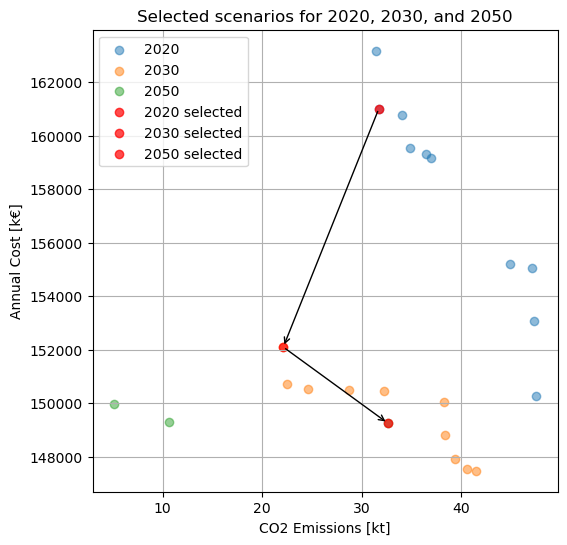

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Plot the scenarios for 2020, 2030, and 2050
for year in targets.keys():
    # Plot the Pareto front
    ax.scatter(
        target_scenarios[year].values[:, 0],
        target_scenarios[year].values[:, 1],
        label=year,
        alpha=0.5,
    )

# Plot the selected scenarios
for i, year in enumerate(targets.keys()):
    ax.scatter(
        target_scenarios[year].values[best_combination[i]][0],
        target_scenarios[year].values[best_combination[i]][1],
        label=f'{year} selected',
        color='red',
        alpha=0.7
    )

# Draw arrows between the selected scenarios
years = list(targets.keys())
for i, year in enumerate(years[:-1]):
    ax.annotate(
        "",
        xy=(target_scenarios[years[i+1]].values[best_combination[i+1]][0],
            target_scenarios[years[i+1]].values[best_combination[i+1]][1]),
        xytext=(target_scenarios[year].values[best_combination[i]][0],
                target_scenarios[year].values[best_combination[i]][1]),
        arrowprops=dict(arrowstyle="->", lw=1)
    )

ax.set_xlabel('CO2 Emissions [kt]')
ax.set_ylabel('Annual Cost [k€]')
ax.set_title('Selected scenarios for 2020, 2030, and 2050')
ax.grid()
ax.legend()
plt.show()

## References

```{bibliography}
:style: unsrt
```